# Cora Citation Network

The Cora network is a directed network where nodes represent scientific papers, an edge between two nodes indicates that the left node cites the right node. In addition the papers are classified to categories.

### Research Question
Which article cites an article from a different category? 


### Imports

In [155]:
# Import packages
import numpy as np
import os
import pandas as pd
import networkx as nx
import time
from random import sample
import sys
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

### Get csv's

In [7]:
# edges.csv has 91500 rows, nodes.csv has 23166 rows
edges = pd.read_csv('./data/edges.csv', delimiter=' ')
nodes = pd.read_csv('./data/nodes.csv', delimiter=' ')
nodes = nodes[['network_id', 'node_id']]

In [109]:
#get id's, get each node id's category and concat them together in names df
names = pd.read_csv('./data/ent.subelj_cora_cora.id.csv', delimiter=' ')
cat = pd.read_csv('./data/ent.subelj_cora_cora.class.csv', delimiter=' ')
names['category'] = cat[['category']]

In [117]:
result

,network_id,category
0,1,/Databases/Performance/
1,2,/Human_Computer_Interaction/Cooperative/
2,3,/Programming/Java/
3,4,/Operating_Systems/Memory_Management/
4,5,/Data_Structures__Algorithms_and_Theory/Parallel/
...,...,...
23161,23162,/Networking/Protocols/
23162,23163,/Artificial_Intelligence/Agents/
23163,23164,/Artificial_Intelligence/Planning/
23164,23165,/Hardware_and_Architecture/Logic_Design/


In [164]:
result = pd.merge(nodes, names, on='node_id')
result = result.drop(['node_id'], axis=1)

## Create Network

In [45]:
edges_tuple = [tuple(x) for x in edges.to_numpy()]
DG = nx.DiGraph()
DG.add_edges_from(edges_tuple)

## Degree Distribution

In [74]:
degree_sequence=sorted(degrees,reverse=True) # degree sequence
print("Degree histogram")
hist={}
for d in degree_sequence:
    if d in hist:
        hist[d]+=1
    else:
        hist[d]=1
print("degree #nodes")
for d in hist:
    print('%d %d' % (d,hist[d]))

Degree histogram
degree #nodes
379 1
292 1
261 1
244 1
230 1
219 1
186 1
177 1
173 1
168 1
164 1
163 2
160 1
158 1
153 1
152 1
150 1
146 1
143 2
137 1
135 1
128 1
127 1
124 2
123 1
119 1
118 1
117 1
116 2
114 3
112 1
110 1
109 1
107 3
106 1
105 1
104 1
103 1
100 2
98 3
97 2
96 2
95 1
93 2
92 4
90 2
89 3
88 2
87 1
85 2
84 3
81 6
80 3
79 1
78 4
77 2
76 5
74 2
73 2
72 2
71 6
70 3
69 5
68 5
67 3
66 4
65 6
64 2
63 6
62 6
61 5
60 5
59 3
58 10
57 8
56 11
55 6
54 8
53 13
52 10
51 9
50 8
49 5
48 7
47 8
46 15
45 13
44 11
43 16
42 25
41 19
40 15
39 30
38 32
37 28
36 41
35 28
34 35
33 44
32 44
31 65
30 42
29 41
28 50
27 67
26 82
25 82
24 93
23 119
22 133
21 130
20 176
19 174
18 197
17 232
16 262
15 298
14 400
13 466
12 529
11 620
10 696
9 895
8 1104
7 1257
6 1533
5 1856
4 2223
3 2628
2 3011
1 3045


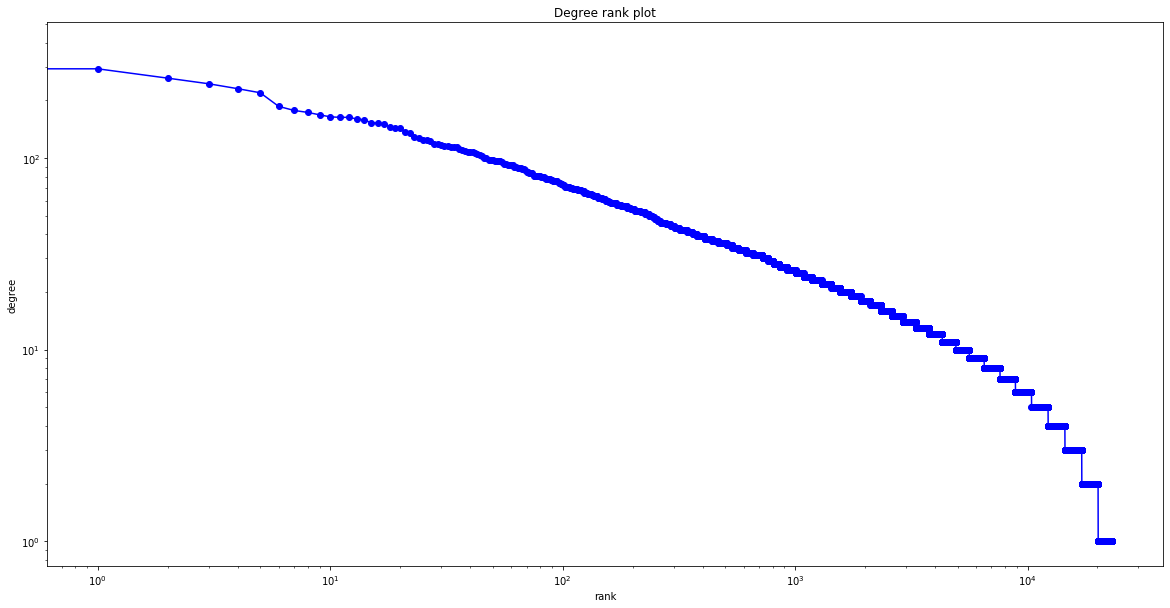

In [83]:
degrees = [DG.degree(n) for n in DG.nodes()]
degree_sequence=sorted(degrees,reverse=True) # degree sequence
dmax=max(degree_sequence)
plt.figure(figsize=(20,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

In [162]:
df = pd.DataFrame({'degree':degree_sequence})
df = df.groupby(['degree']).size()
df

,degree
0,379
1,292
2,261
3,244
4,230
...,...
23161,1
23162,1
23163,1
23164,1


In [153]:
# Plot the data on a graph to see the nodes before and after clustering. 
fig =  plotly.subplots.make_subplots(rows=1, cols=1, horizontal_spacing=0.03, specs=[[{"type": "xy"}]])
fig.add_trace(
    go.Scatter( x=hist.keys.values, y=hist.items, marker_symbol='hexagon2', mode="markers+text", 
               marker=dict(size=12,color='rgba(135, 206, 250, 0.7)', line=dict(width=1, color='DarkSlateGrey'))),
    row=1, col=1)
fig.update_xaxes(title_text="x", row=1, col=1)
fig.update_yaxes(title_text="y", row=1, col=1)
fig.update_layout(height=600, width=1000,
                  title_text="Degree Distribution", showlegend=False)
fig.show()

ValueError: 
    Invalid value of type 'builtins.builtin_function_or_method' received for the 'x' property of scatter
        Received value: <built-in method keys of dict object at 0x000001CDA29A7958>

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [131]:
# Get the node with highest degree
node_degree = [(DG.degree(n), n) for n in DG.nodes()]
node_degree = sorted(node_degree,reverse=True)
print("degree, node_id")
node_degree[:10]

degree, node_id


[(379, 18506),
 (292, 9814),
 (261, 17298),
 (244, 8044),
 (230, 10557),
 (219, 6001),
 (186, 22529),
 (177, 22092),
 (173, 20584),
 (168, 5780)]

## In Degree and out Degree

In [137]:
#get category of node with highest degree
cat_of_highest_degree = result.loc[result['network_id'] == 18506]
print("Category of node with highest degree is ", cat_of_highest_degree['category'])
print("In degree of node with highest degree (node 18506) is ", DG.in_degree(18506))
print("Out degree of node with highest degree (node 18506) is ", DG.out_degree(18506))

Category of node with highest degree is  18505    /Artificial_Intelligence/Expert_Systems/
Name: category, dtype: object
In degree of node with highest degree (node 18506) is  376
Out degree of node with highest degree (node 18506) is  3


we can see that the in and out degree sum up to 379 as we calculated above in degree.

## Degree Centrality

In [138]:
nx.degree_centrality(DG)

{20128: 0.00038851715950787827,
 6078: 0.00017267429311461257,
 22236: 0.001208720051802288,
 10436: 0.00025901143967191884,
 16776: 0.000302180012950572,
 9779: 0.0008633714655730629,
 21082: 0.0005611914526224909,
 12503: 0.00047485430606518457,
 9692: 0.00043168573278653144,
 10344: 0.000604360025901144,
 8806: 0.00038851715950787827,
 7158: 0.0005611914526224909,
 5318: 0.00043168573278653144,
 5897: 0.001208720051802288,
 1701: 0.0005180228793438377,
 12079: 0.000302180012950572,
 15275: 0.001165551478523635,
 10745: 0.000302180012950572,
 22237: 0.00047485430606518457,
 20015: 0.001813080077703432,
 19319: 0.00025901143967191884,
 19032: 0.003971508741636089,
 11750: 0.00038851715950787827,
 1152: 0.0010360457586876754,
 2341: 0.00017267429311461257,
 10933: 0.00017267429311461257,
 15483: 0.0008202028922944097,
 14269: 0.0020720915173753508,
 1276: 0.000302180012950572,
 5795: 0.0012950571983595942,
 15944: 4.316857327865314e-05,
 16552: 0.00034534858622922514,
 875: 0.000172674

## Betweenness 

In [165]:
nx.betweenness_centrality(DG)

KeyboardInterrupt: 

## Community Detection

Check if we get a community with articles with different categories rather than a community with all articles from the same category.

## Embeddedness  